In [1]:
# import packages needed for entire model

import tensorflow as tf
import tensorboard
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
from keras import metrics
import sys
import h5py

# mount to google drive in order to pull data file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
terminal = sys.stdout

Mounted at /content/drive


In [2]:
# import data file, splice data, split into testing and training data

subsetSize= 1000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
#sample = hf["sample_id"][0:subsetSize + validationSize]
imgs = hf['images'][0:subsetSize + validationSize]
spectra = hf['spectra'][0:subsetSize + validationSize]
spectra = np.array([x[::splicingVal] for x in spectra])
imgsNN = imgs[0:subsetSize]
spectraNN = spectra[0:subsetSize]
x_valid = imgs[subsetSize:subsetSize+validationSize]
y_valid = spectra[subsetSize:subsetSize+validationSize]
x_train, x_test, y_train, y_test = train_test_split(imgsNN, spectraNN, test_size = 0.2, random_state = None)

In [ ]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
 #   tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'softsign')])
    model.summary()
    adamOpti = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer= adamOpti, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

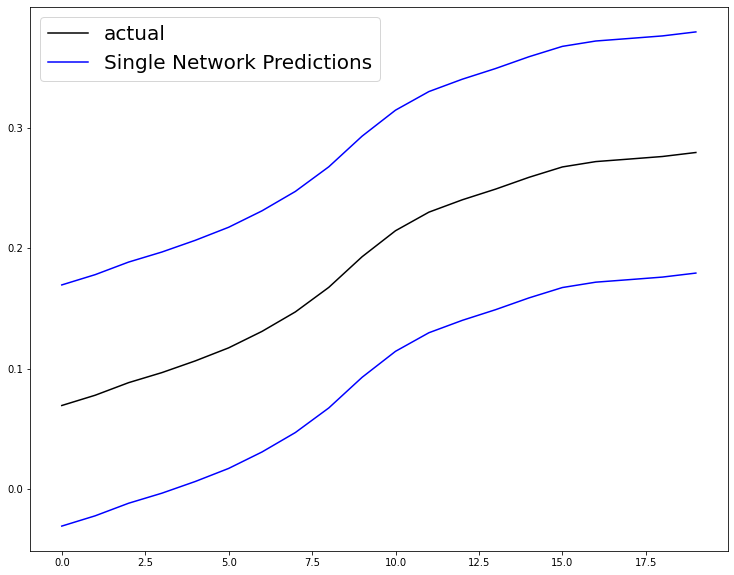

In [28]:
spectra = np.array(spectra)
i = 99 
fig = plt.figure(figsize = (12.5,10))
plt.plot(spectra[i], color = 'black', label = 'actual')
plt.plot(spectra[i]+.1, color = 'b', label = 'Single Network Predictions')
plt.plot(spectra[i]-.1, color = 'b')
#plt.title('UQ Example', fontsize = 40)
plt.legend(fontsize = 20)

In [ ]:
# Running Neural Network with averaging Ensemble, including tensorboard and early stopping

# Define number of networks, batches, and epochs 

numNetworks = 2
epochs = 50
batch_size = 25
log_folder = 'logs'

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)


modelList = []
historyList= []
#epochOutput = open('EpochOutput1.txt', 'w')
for i in range(numNetworks):
  with open('EpochOutput.txt', 'a') as f:
    sys.stdout = f
    normal_model = get_conv_model_normal()
  sys.stdout = terminal
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1,
                callbacks= [early_stopping])
  modelList.append(normal_model)
  historyList.append(normal_history)
#  sys.stdout = terminal

# Create predictions based on results of the neural network and ensemble 

def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble

def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

# Create the arithmetic average of the output spectra from the predicted values from the ensemble, commented out for now for simplicity

def ensemblePredictArithAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 0
  for predict in predictList:
    prediction += predict[ele]
  return prediction/numNetworks

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


32/32 [==============================] - 1s 17ms/step - loss: 0.1306 - mean_squared_error: 0.1306 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.3453e-04 - val_mean_squared_error: 9.3453e-04
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 8.3324e-04 - mean_squared_error: 8.3324e-04 - val_loss: 8.9565e-04 - val_mean_squared_error: 8.9565e-04
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 8.2666e-04 - mean_squared_error: 8.2666e-04 - val_loss: 8.3818e-04 - val_mean_squared_error: 8.3818e-04
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 7.6011e-04 - mean_squared_error: 7.6011e-04 - val_loss: 8.0816e-04 - val_mean_squared_error: 8.0816e-04
Epoch 6/50
32/32 [==============================] - 0s 10ms/step - loss: 7.5724e-04 - mean_squared_error: 7.5724e-04 - val_loss: 8.1620e-04 - val_mean

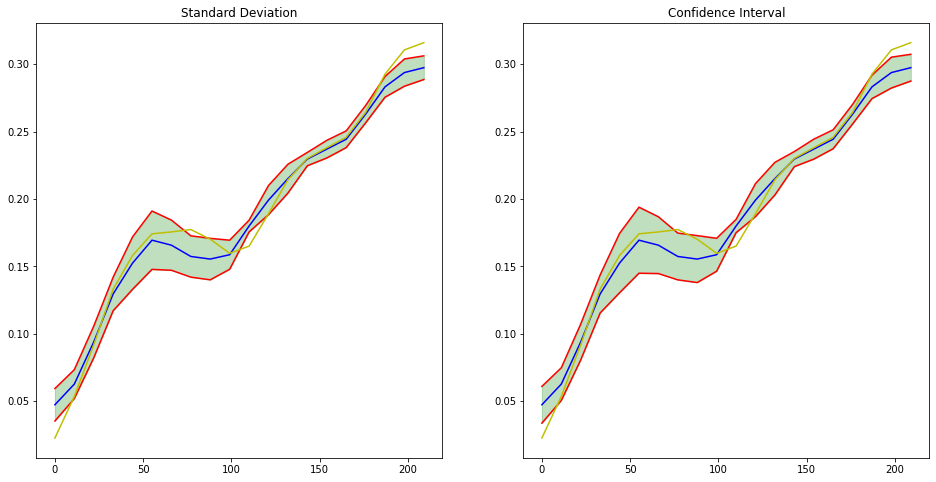

In [ ]:
# --- New ---
def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = np.array([ensemblePredictArithAverage(predictList, ele) for ele in range(len(x_valid))])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])


# Plot lines
for i in range(len(x_valid)):
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))
  topUQ = y[i]+UQ[i]
  botUQ = y[i]-UQ[i]
  ax[0].plot(x, topUQ, color="red")
  ax[0].plot(x, botUQ, color="red")


  # Fill area when income > expenses with green
  ax[0].fill_between(
      x, topUQ, botUQ, where=(topUQ > botUQ), 
      interpolate=True, color="green", alpha=0.25, 
      label="Positive"
  )

  ax[0].plot(x, y[i], color="blue")
  ax[0].plot(x, y_valid[i], color = 'y')
  ax[0].set_title('Standard Deviation')
  # Plot lines
  i = 0
  topUQ = y[i]+1.96*UQ[i]/np.sqrt(numNetworks)
  botUQ = y[i]-1.96*UQ[i]/np.sqrt(numNetworks)
  ax[1].plot(x, topUQ, color="red")
  ax[1].plot(x, botUQ, color="red")


  # Fill area when income > expenses with green
  ax[1].fill_between(
      x, topUQ, botUQ, where=(topUQ > botUQ), 
      interpolate=True, color="green", alpha=0.25, 
      label="Positive"
  )

  ax[1].plot(x, y[i], color="blue")
  ax[1].plot(x, y_valid[i], color = 'y')
  ax[1].set_title('Confidence Interval')
  fig.show()

TypeError: ignored

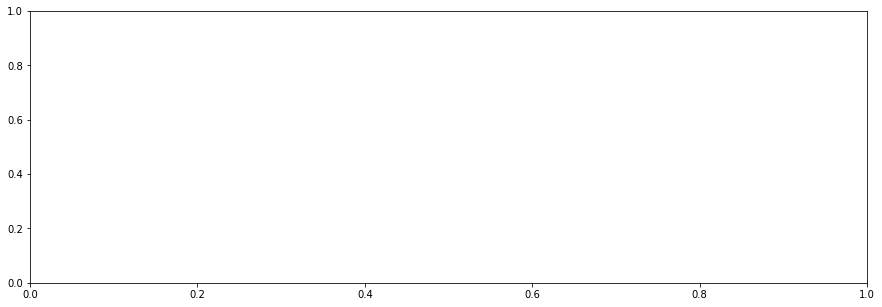

In [ ]:
def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n, n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

low, high = closest_factor(numNetworks)
fig, axs = plt.subplots(low, high, figsize=(5*numNetworks, 5))
for i, ax1 in enumerate(axs):
  for ax in enumerate(ax1):
    y = historyList[i].history
    ax.plot(y['mean_squared_error'], color = 'b')
    ax.plot(y['val_mean_squared_error'], color = 'y')
    ax.set(xlabel='Epoch', ylabel='MSE')
    ax.legend(['MSE training data', 'MSE validation data'], prop={'size': 12})
 # font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 12}
 # ax.text(10, 0.27, f"Final Validation MSE: {normal_history.history['val_mean_squared_error'][-1]}", fontdict = font)
fig.suptitle('Mean Squared Error (MSE) Over Time', fontsize = 20)
plt.savefig('MSE_Plot.jpg')

Text(0.5, 0.98, 'Mean Squared Error (MSE) Over Time')

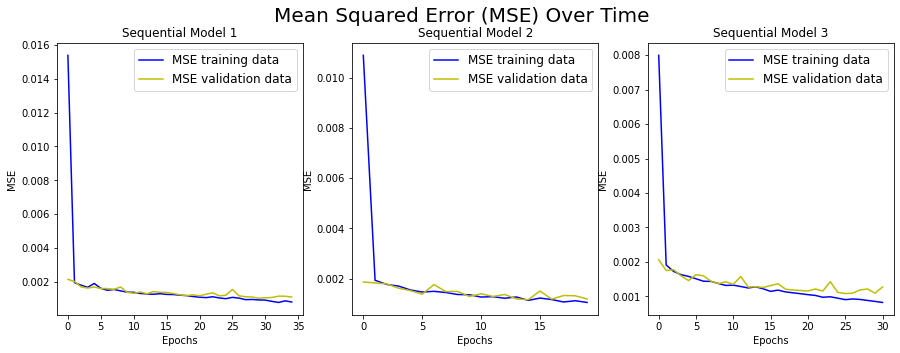

In [ ]:
from IPython.core.pylabtools import figsize
def closest_factor(num):
  n = int(np.ceil(np.sqrt(num)))
  if num % n == 0:
    return n, n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

low, high = closest_factor(numNetworks)
fig = plt.figure(1, figsize = (5*high,5*low))
plt.title('Mean Squared Error (MSE) Over Time', fontsize = 20)
for i in range(low):
  for j in range(high):
    index = high*i + j
    y = historyList[index].history
    plt.subplot(low, high, index+1)
    plt.plot(y['mean_squared_error'], color = 'b')
    plt.plot(y['val_mean_squared_error'], color = 'y')
    plt.title(f'Sequential Model {index+1}')
    plt.legend(['MSE training data', 'MSE validation data'], prop={'size': 12})
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
fig.suptitle('Mean Squared Error (MSE) Over Time', fontsize = 20)

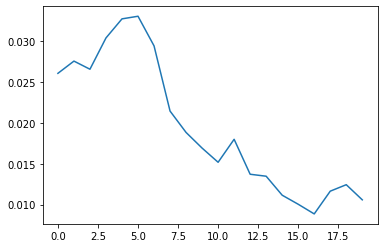

In [ ]:
x = np.array([x for x in range(0,220,splicingVal)])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
plt.plot(UQ[i])

Accuracy = 0.7
Total MSE = 0.00012762894039042294


[Text(0, 0.5, 'y_predicted'), Text(0.5, 0, 'y_actual')]

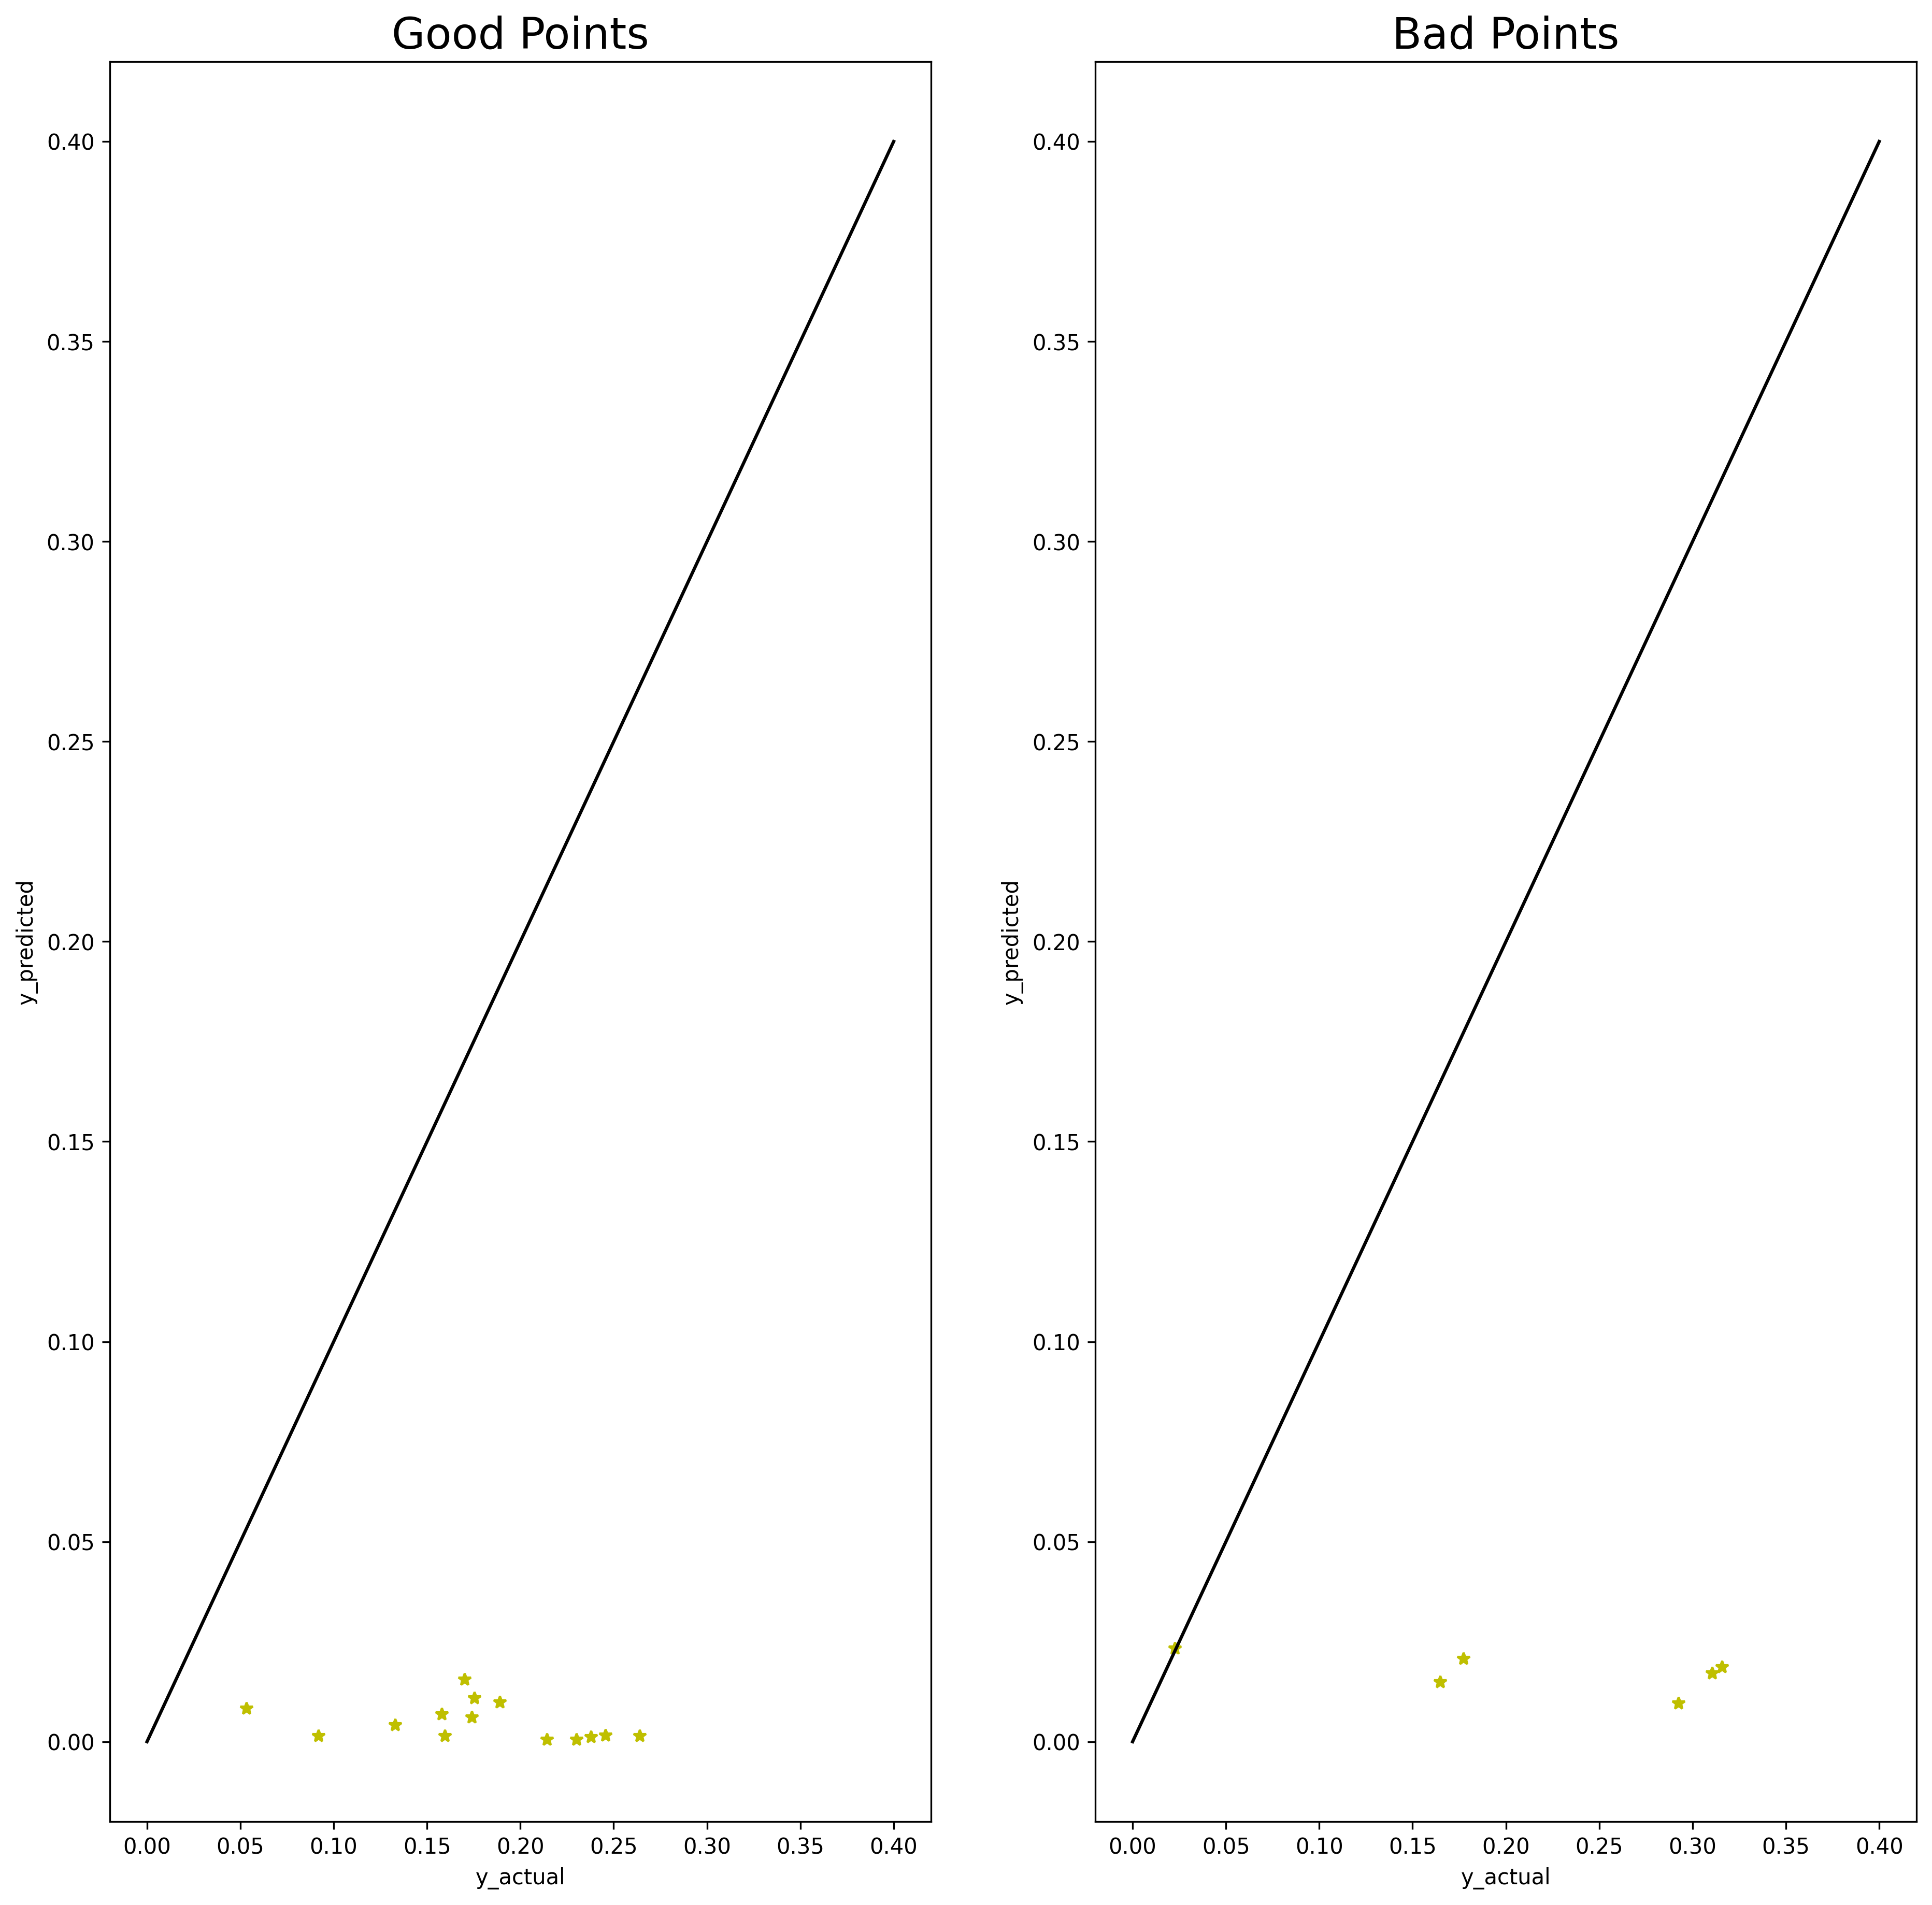

In [ ]:
# accuracy thingy majig

y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
goodX, goodY = [], []
badX, badY = [], []
for i, spectra in enumerate(np.abs(y_pred - y_valid)):
  for j, ele in enumerate(spectra):
    if ele < UQ[i][j]*1.96/np.sqrt(numNetworks):
      goodY.append(ele)
      goodX.append(y_valid[i][j])
    else:
      badY.append(ele)
      badX.append(y_valid[i][j])
print(f'Accuracy = {len(goodX)/(20*len(x_valid))}')
print(f'Total MSE = {np.mean((y_valid-y_pred)**2)}')
fig, ax = plt.subplots(1, 2, figsize=(15, 15), dpi=300)
ax[0].plot(goodX, goodY, '*', color = 'y')
a, b = 0, .4 
ax[0].plot([a,b],[a,b], color='black')
ax[0].set_title('Good Points', fontsize = 20)
ax[0].set(xlabel='y_actual', ylabel='y_predicted')

ax[1].plot(badX, badY, '*', color = 'y')
a, b = 0, .4 
ax[1].plot([a,b],[a,b], color='black')
ax[1].set_title('Bad Points', fontsize = 20)
ax[1].set(xlabel='y_actual', ylabel='y_predicted')

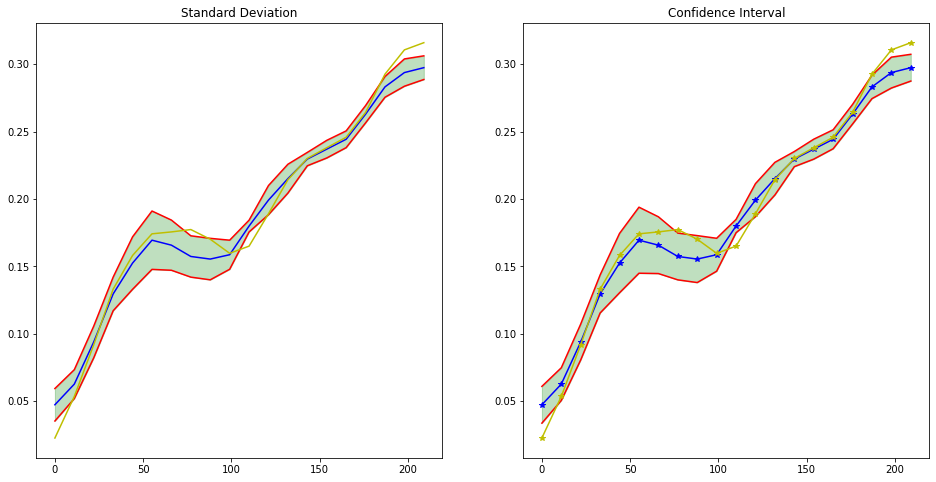

In [ ]:
# --- New ---
def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = np.array([ensemblePredictArithAverage(predictList, ele) for ele in range(len(x_valid))])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])


# Plot lines
for i in range(1):
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))
  topUQ = y[i]+UQ[i]
  botUQ = y[i]-UQ[i]
  ax[0].plot(x, topUQ, color="red")
  ax[0].plot(x, botUQ, color="red")


  # Fill area when income > expenses with green
  ax[0].fill_between(
      x, topUQ, botUQ, where=(topUQ > botUQ), 
      interpolate=True, color="green", alpha=0.25, 
      label="Positive"
  )

  ax[0].plot(x, y[i], color="blue")
  ax[0].plot(x, y_valid[i], color = 'y')
  ax[0].set_title('Standard Deviation')
  # Plot lines
  i = 0
  topUQ = y[i]+1.96*UQ[i]/np.sqrt(numNetworks)
  botUQ = y[i]-1.96*UQ[i]/np.sqrt(numNetworks)
  ax[1].plot(x, topUQ, color="red")
  ax[1].plot(x, botUQ, color="red")


  # Fill area when income > expenses with green
  ax[1].fill_between(
      x, topUQ, botUQ, where=(topUQ > botUQ), 
      interpolate=True, color="green", alpha=0.25, 
      label="Positive"
  )

  ax[1].plot(x, y[i], color="blue", marker='*')
  ax[1].plot(x, y_valid[i], color = 'y', marker='*')
  ax[1].set_title('Confidence Interval')
  fig.show()

Accuracy = 0.7
Total MSE = 0.00012762894039042294


[Text(0, 0.5, 'y_predicted'), Text(0.5, 0, 'y_actual')]

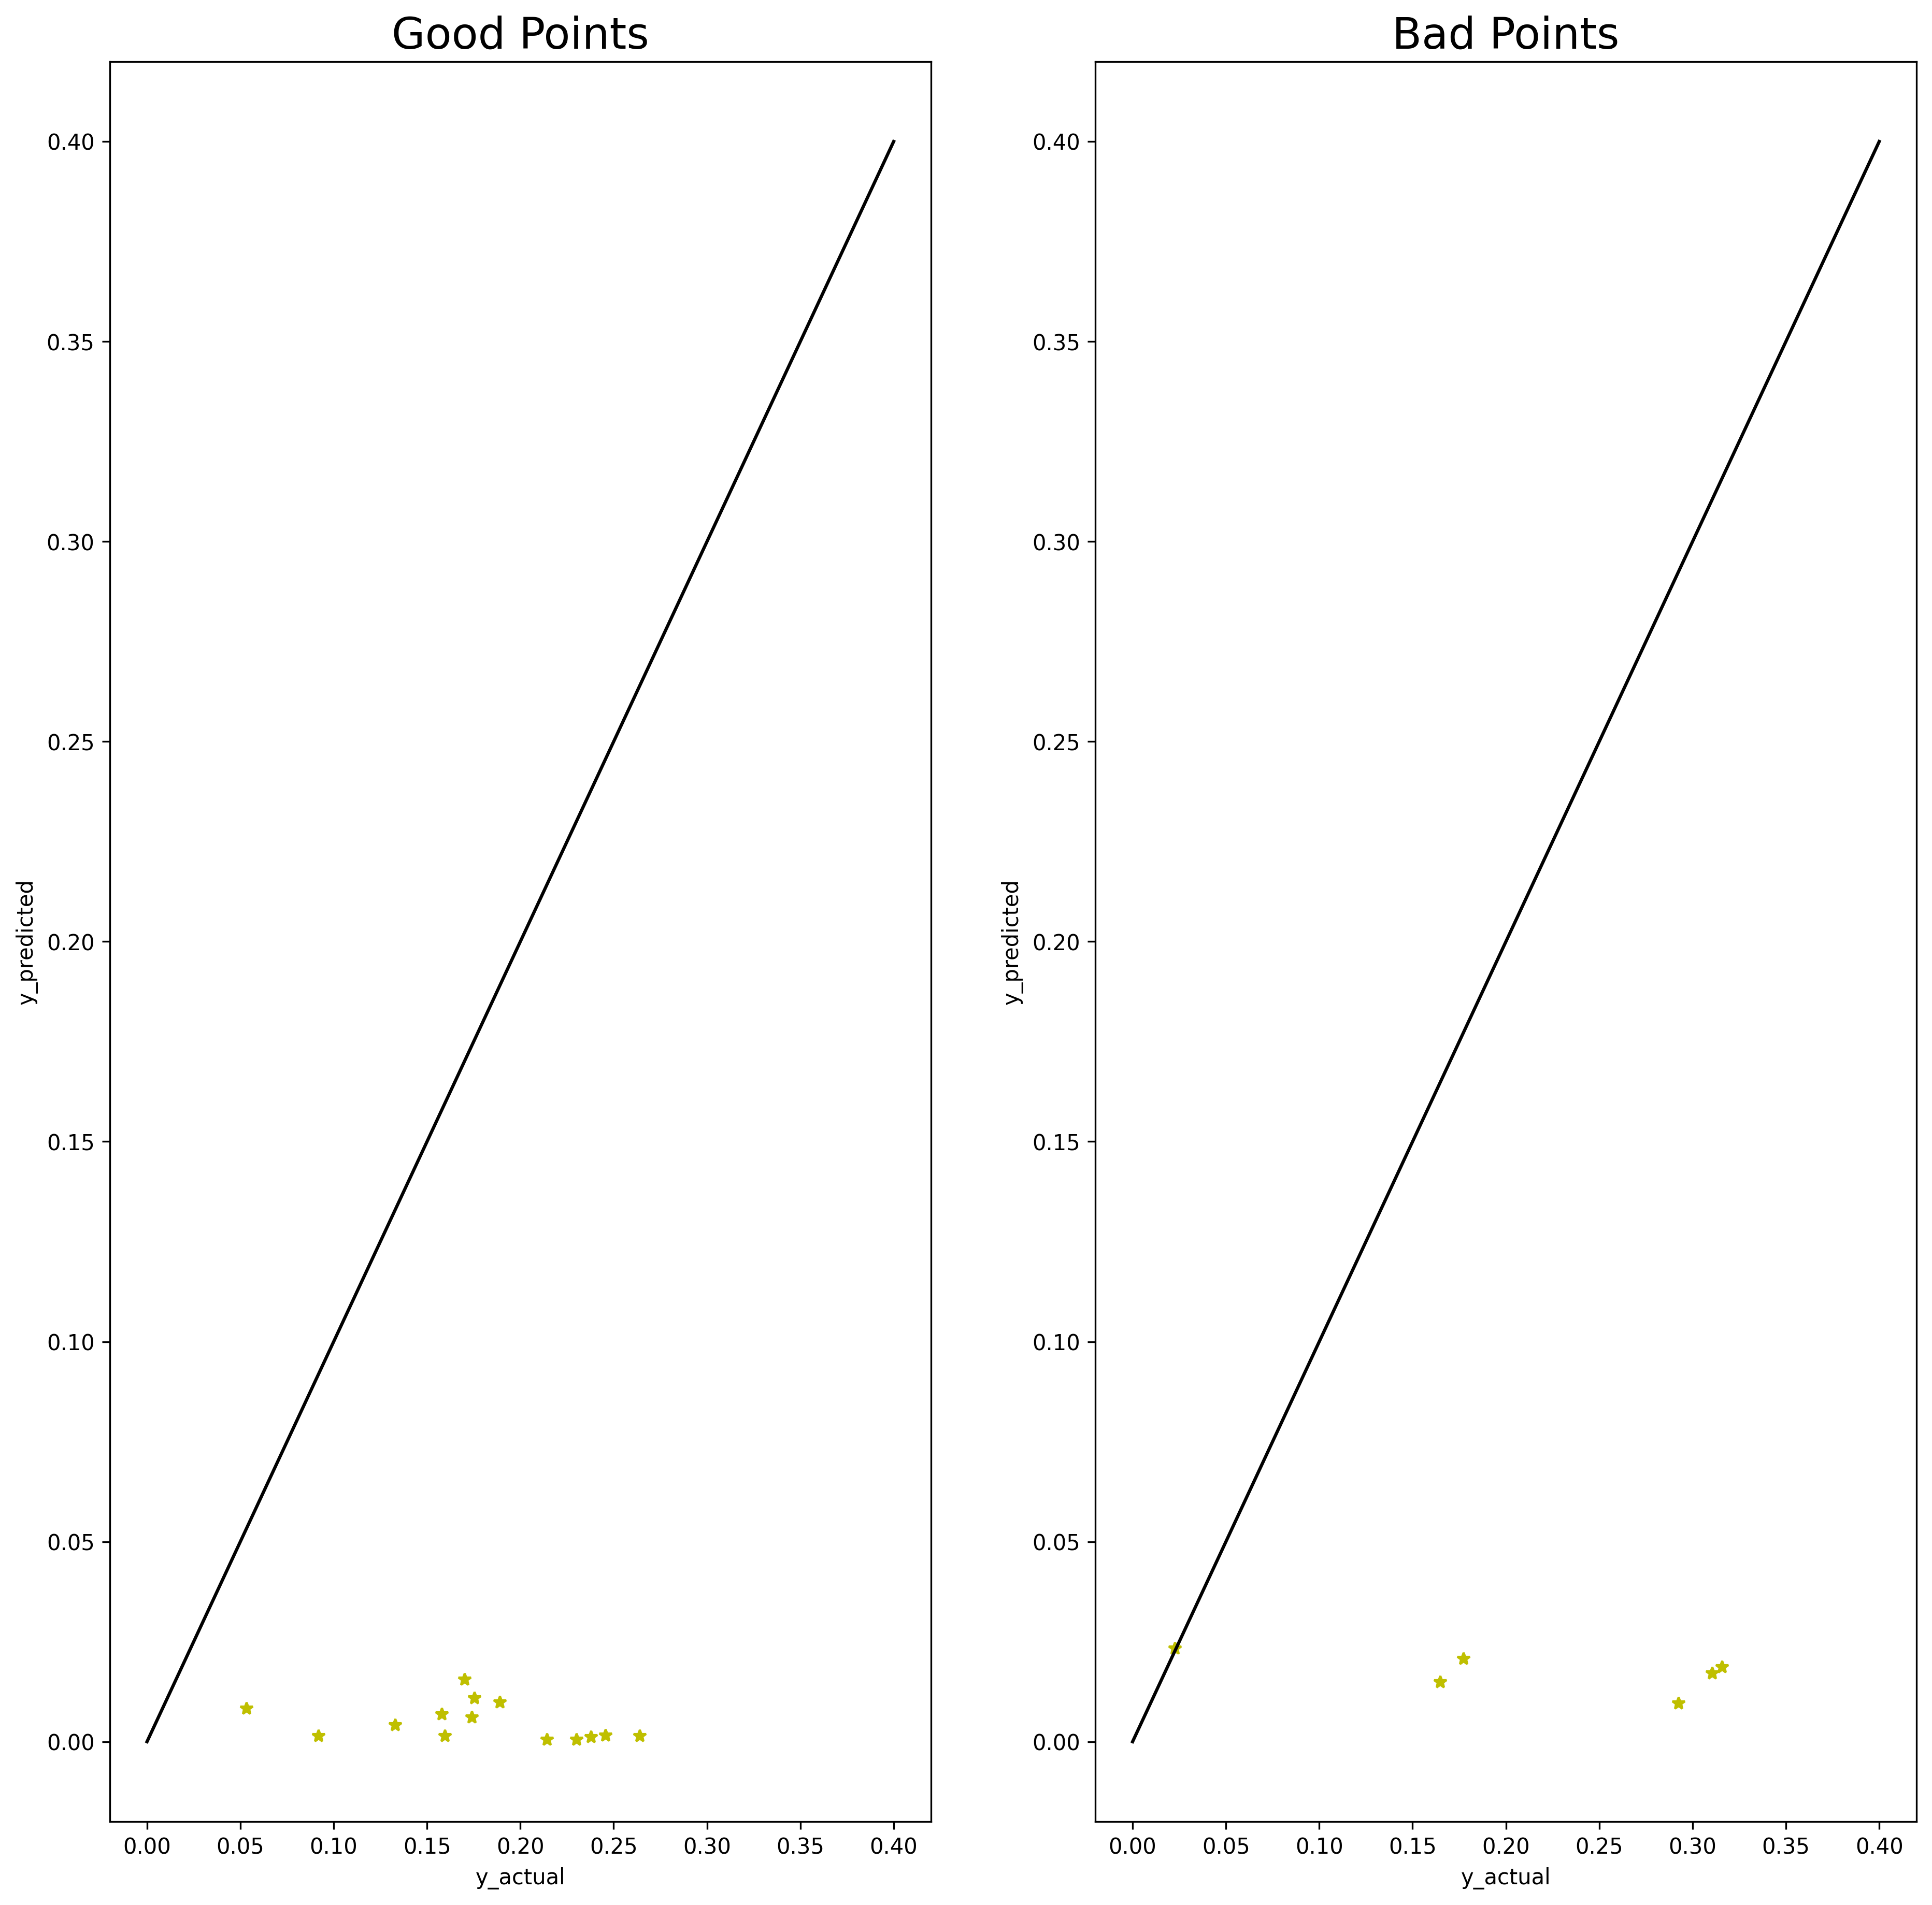

In [ ]:
# accuracy thingy majig

y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
goodX, goodY = [], []
badX, badY = [], []
#for i, spectra in enumerate(np.abs(y_pred - y_valid)):
i = 0
for j, ele in enumerate(np.abs(y_pred - y_valid)[i]):
  if ele < UQ[i][j]*1.96/np.sqrt(numNetworks):
    goodY.append(ele)
    goodX.append(y_valid[i][j])
  else:
    badY.append(ele)
    badX.append(y_valid[i][j])
print(f'Accuracy = {len(goodX)/(20*len(x_valid))}')
print(f'Total MSE = {np.mean((y_valid-y_pred)**2)}')
fig, ax = plt.subplots(1, 2, figsize=(15, 15), dpi=300)
ax[0].plot(goodX, goodY, '*', color = 'y')
a, b = 0, .4 
ax[0].plot([a,b],[a,b], color='black')
ax[0].set_title('Good Points', fontsize = 20)
ax[0].set(xlabel='y_actual', ylabel='y_predicted')

ax[1].plot(badX, badY, '*', color = 'y')
a, b = 0, .4 
ax[1].plot([a,b],[a,b], color='black')
ax[1].set_title('Bad Points', fontsize = 20)
ax[1].set(xlabel='y_actual', ylabel='y_predicted')

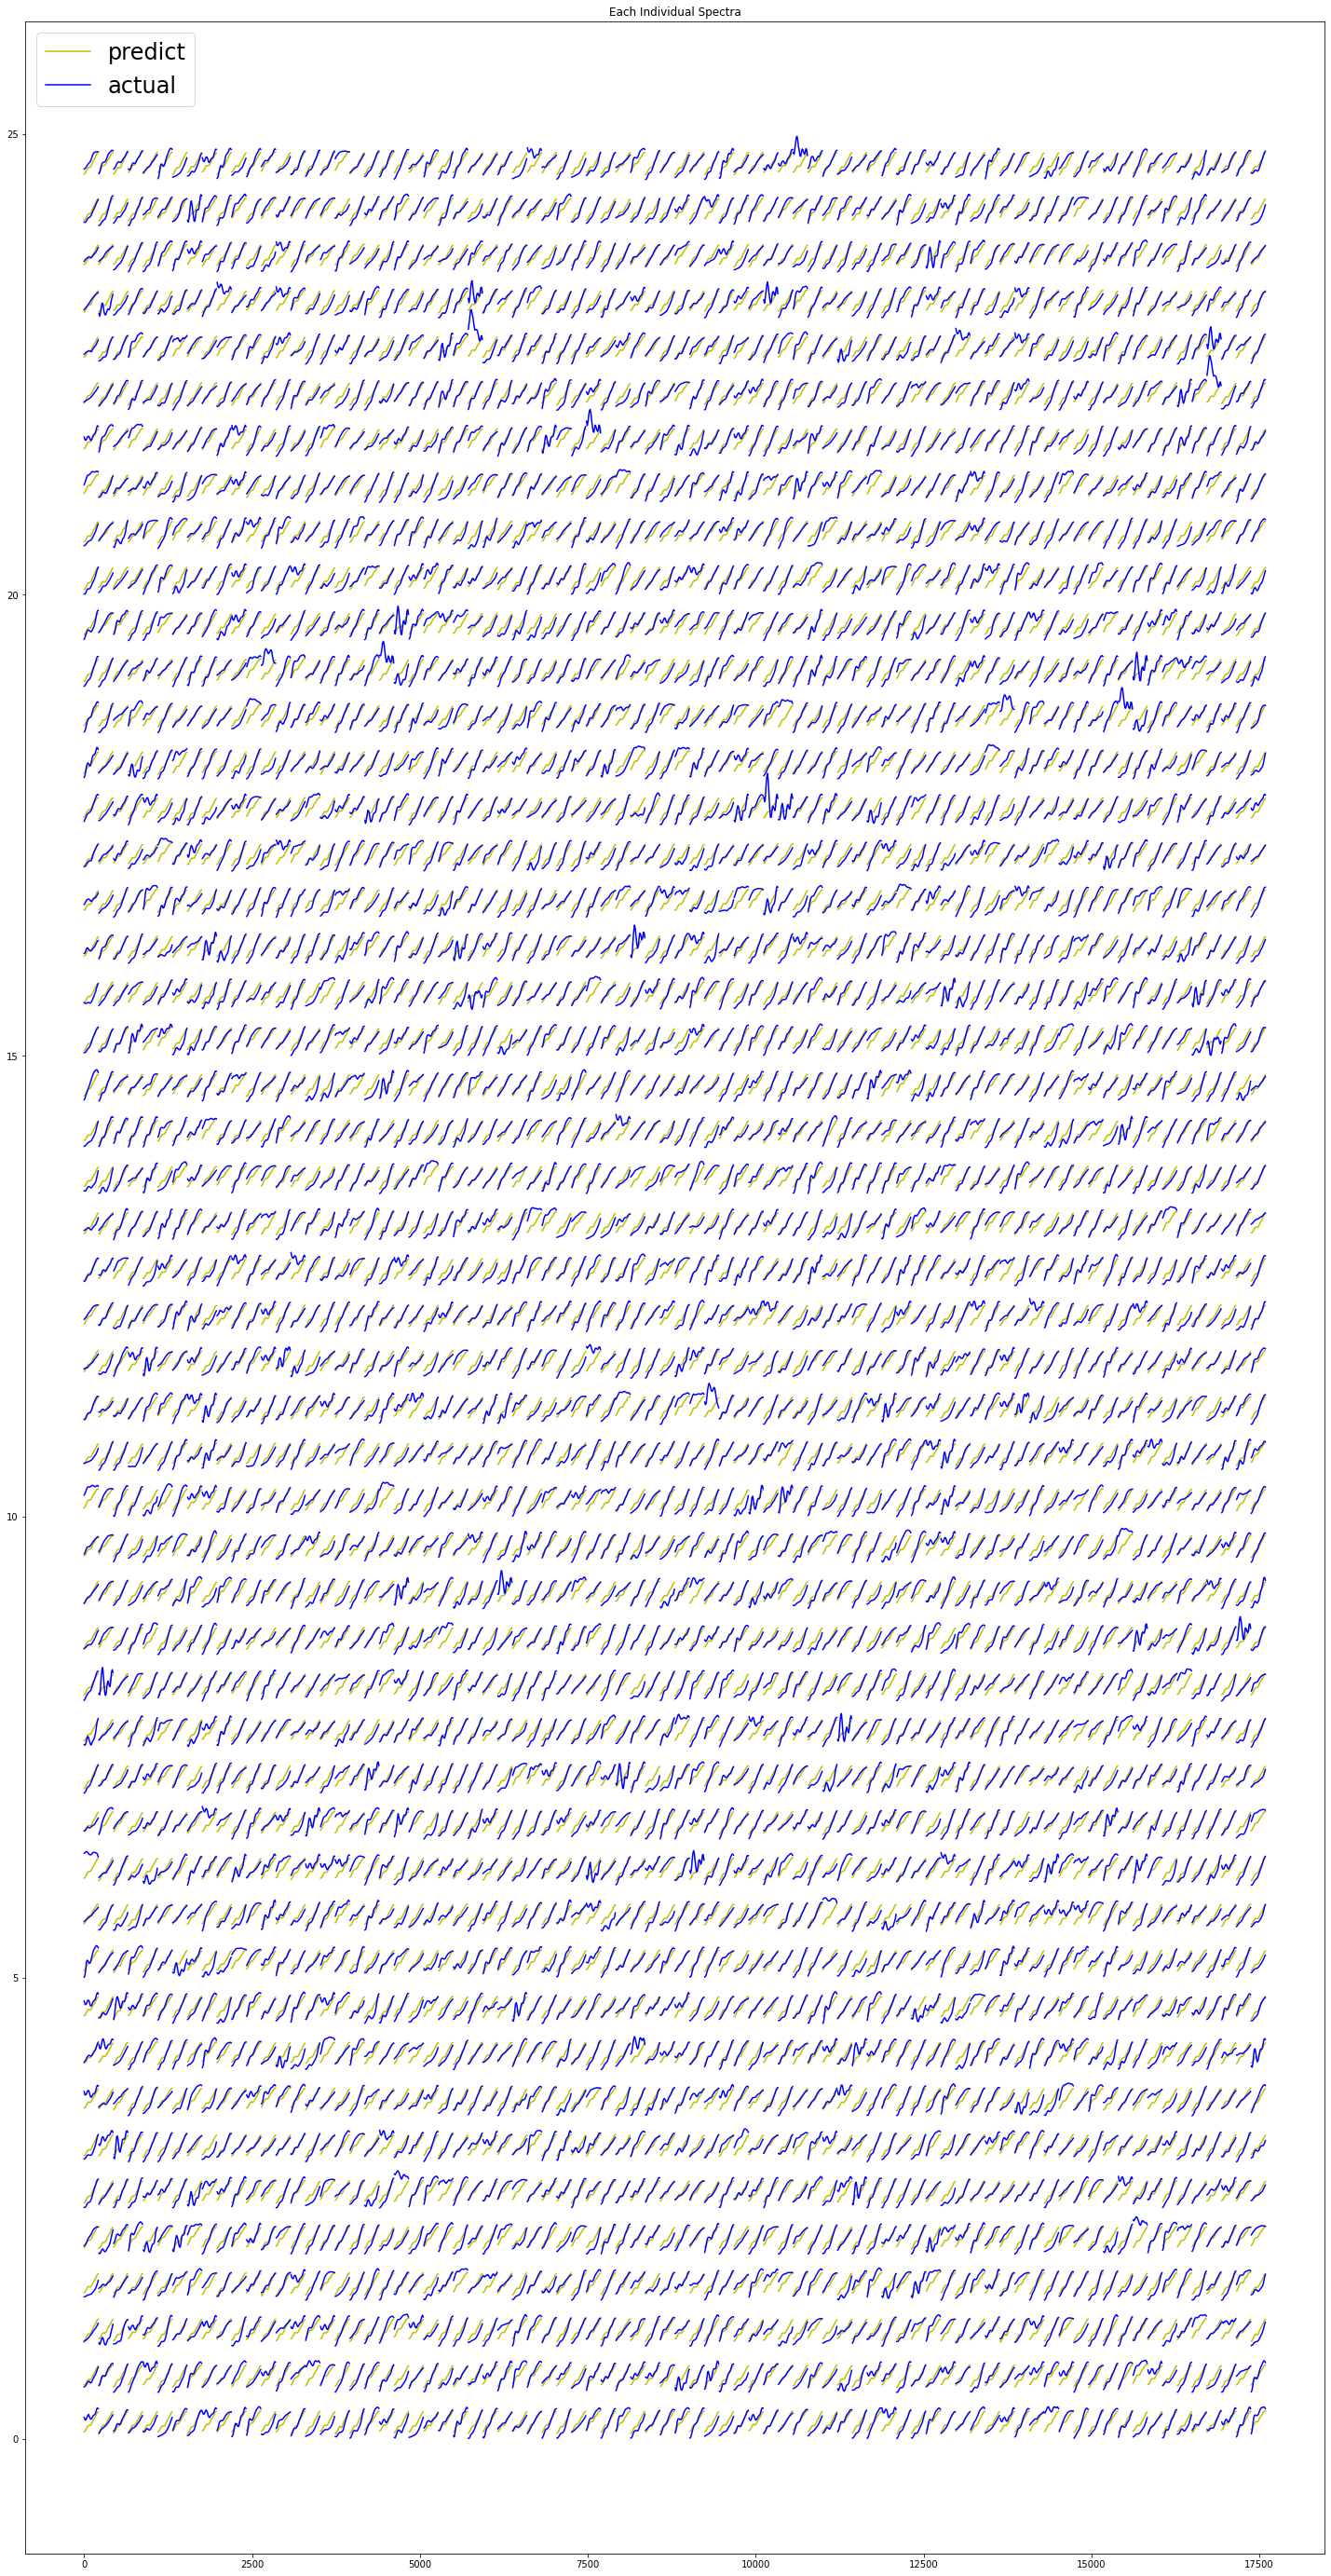

In [ ]:
# DO NOT RUN UNLESS NEEDED - not visually easy on the eyes and 100 random is better
# Creates Grid of All Spectras in Testing set

def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_test)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]
fig = plt.figure(figsize=(25, 50))
low, high = closest_factor(len(x_test))
for j in range(low):
  for i in range(high):
    plt.plot(x + 220*i, y[50*j+i]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_test[50*j+i]+.5*j, color = 'b')
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Each Individual Spectra', fontsize = 20)
plt.savefig('EverySpectra.jpg')
plt.show()

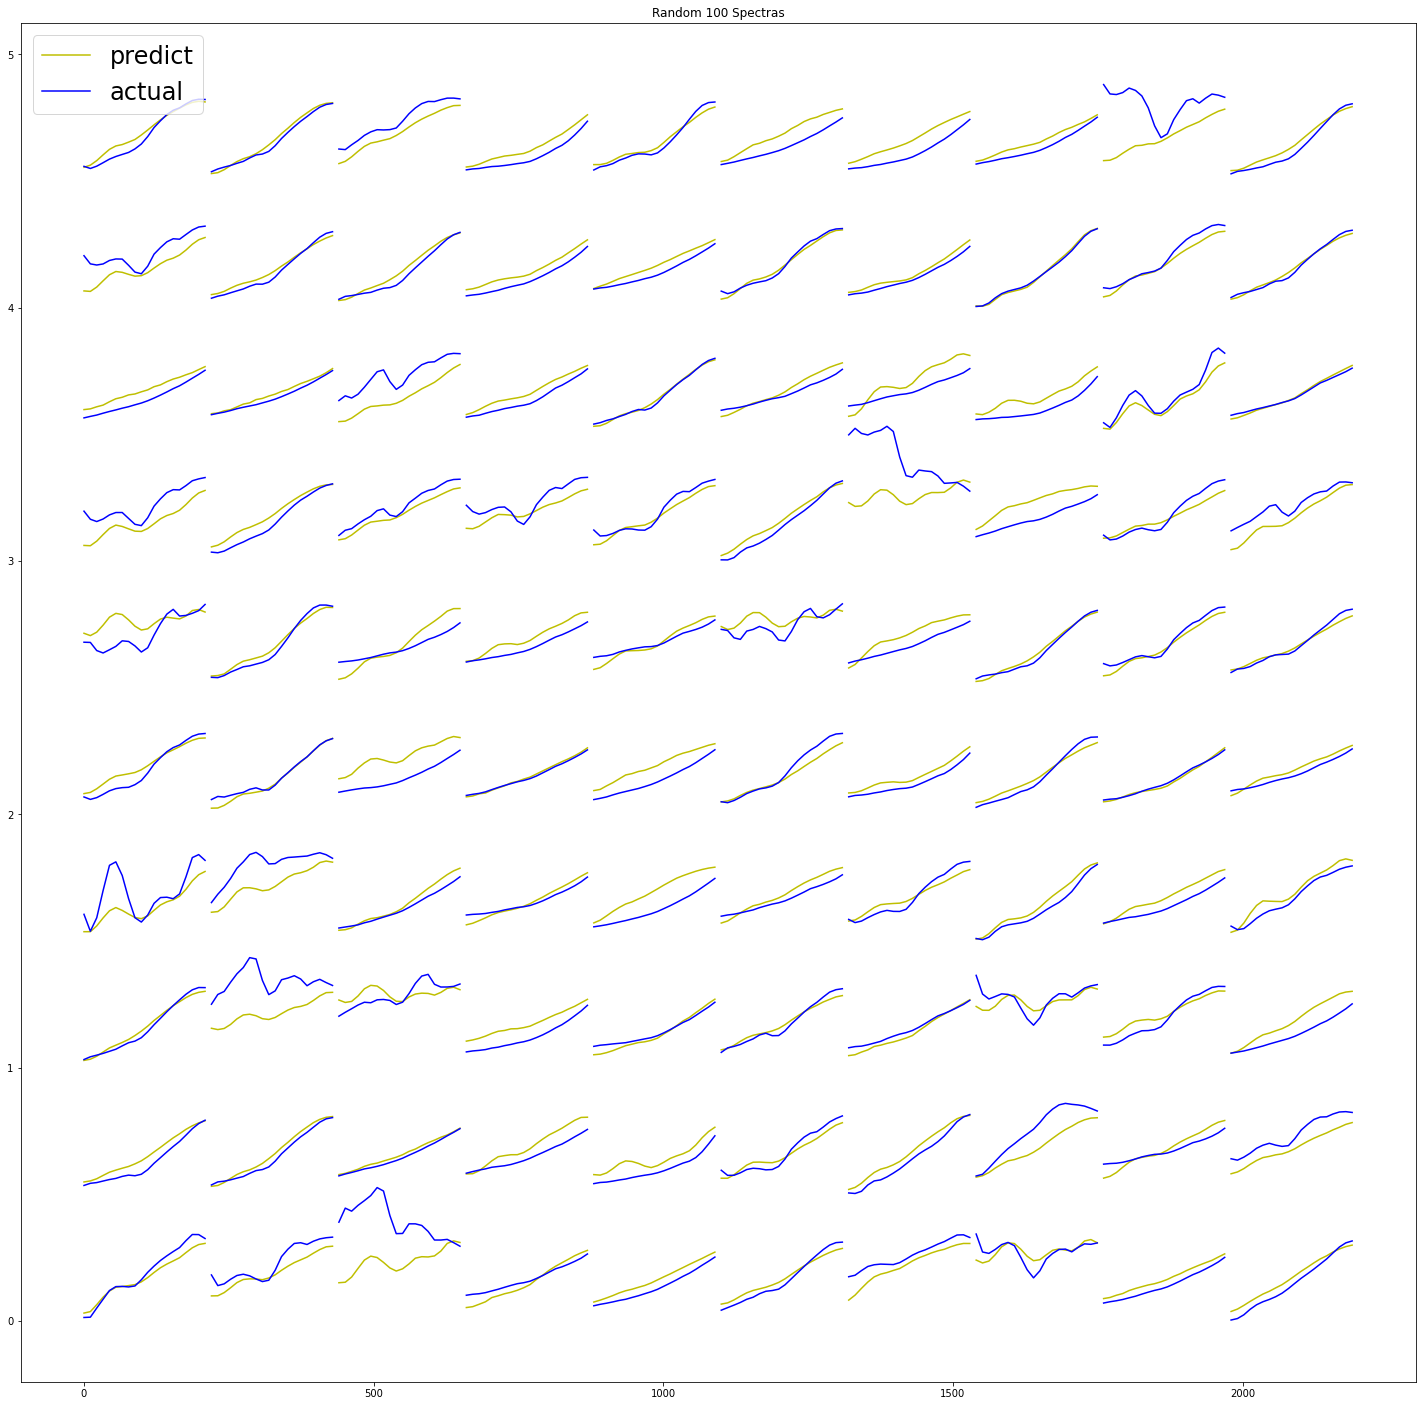

In [ ]:
# Creates Random 100 Grid of Spectras from Validation Data

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'b')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras', fontsize = 20)
plt.savefig('Random100Grid.jpg')
plt.show()

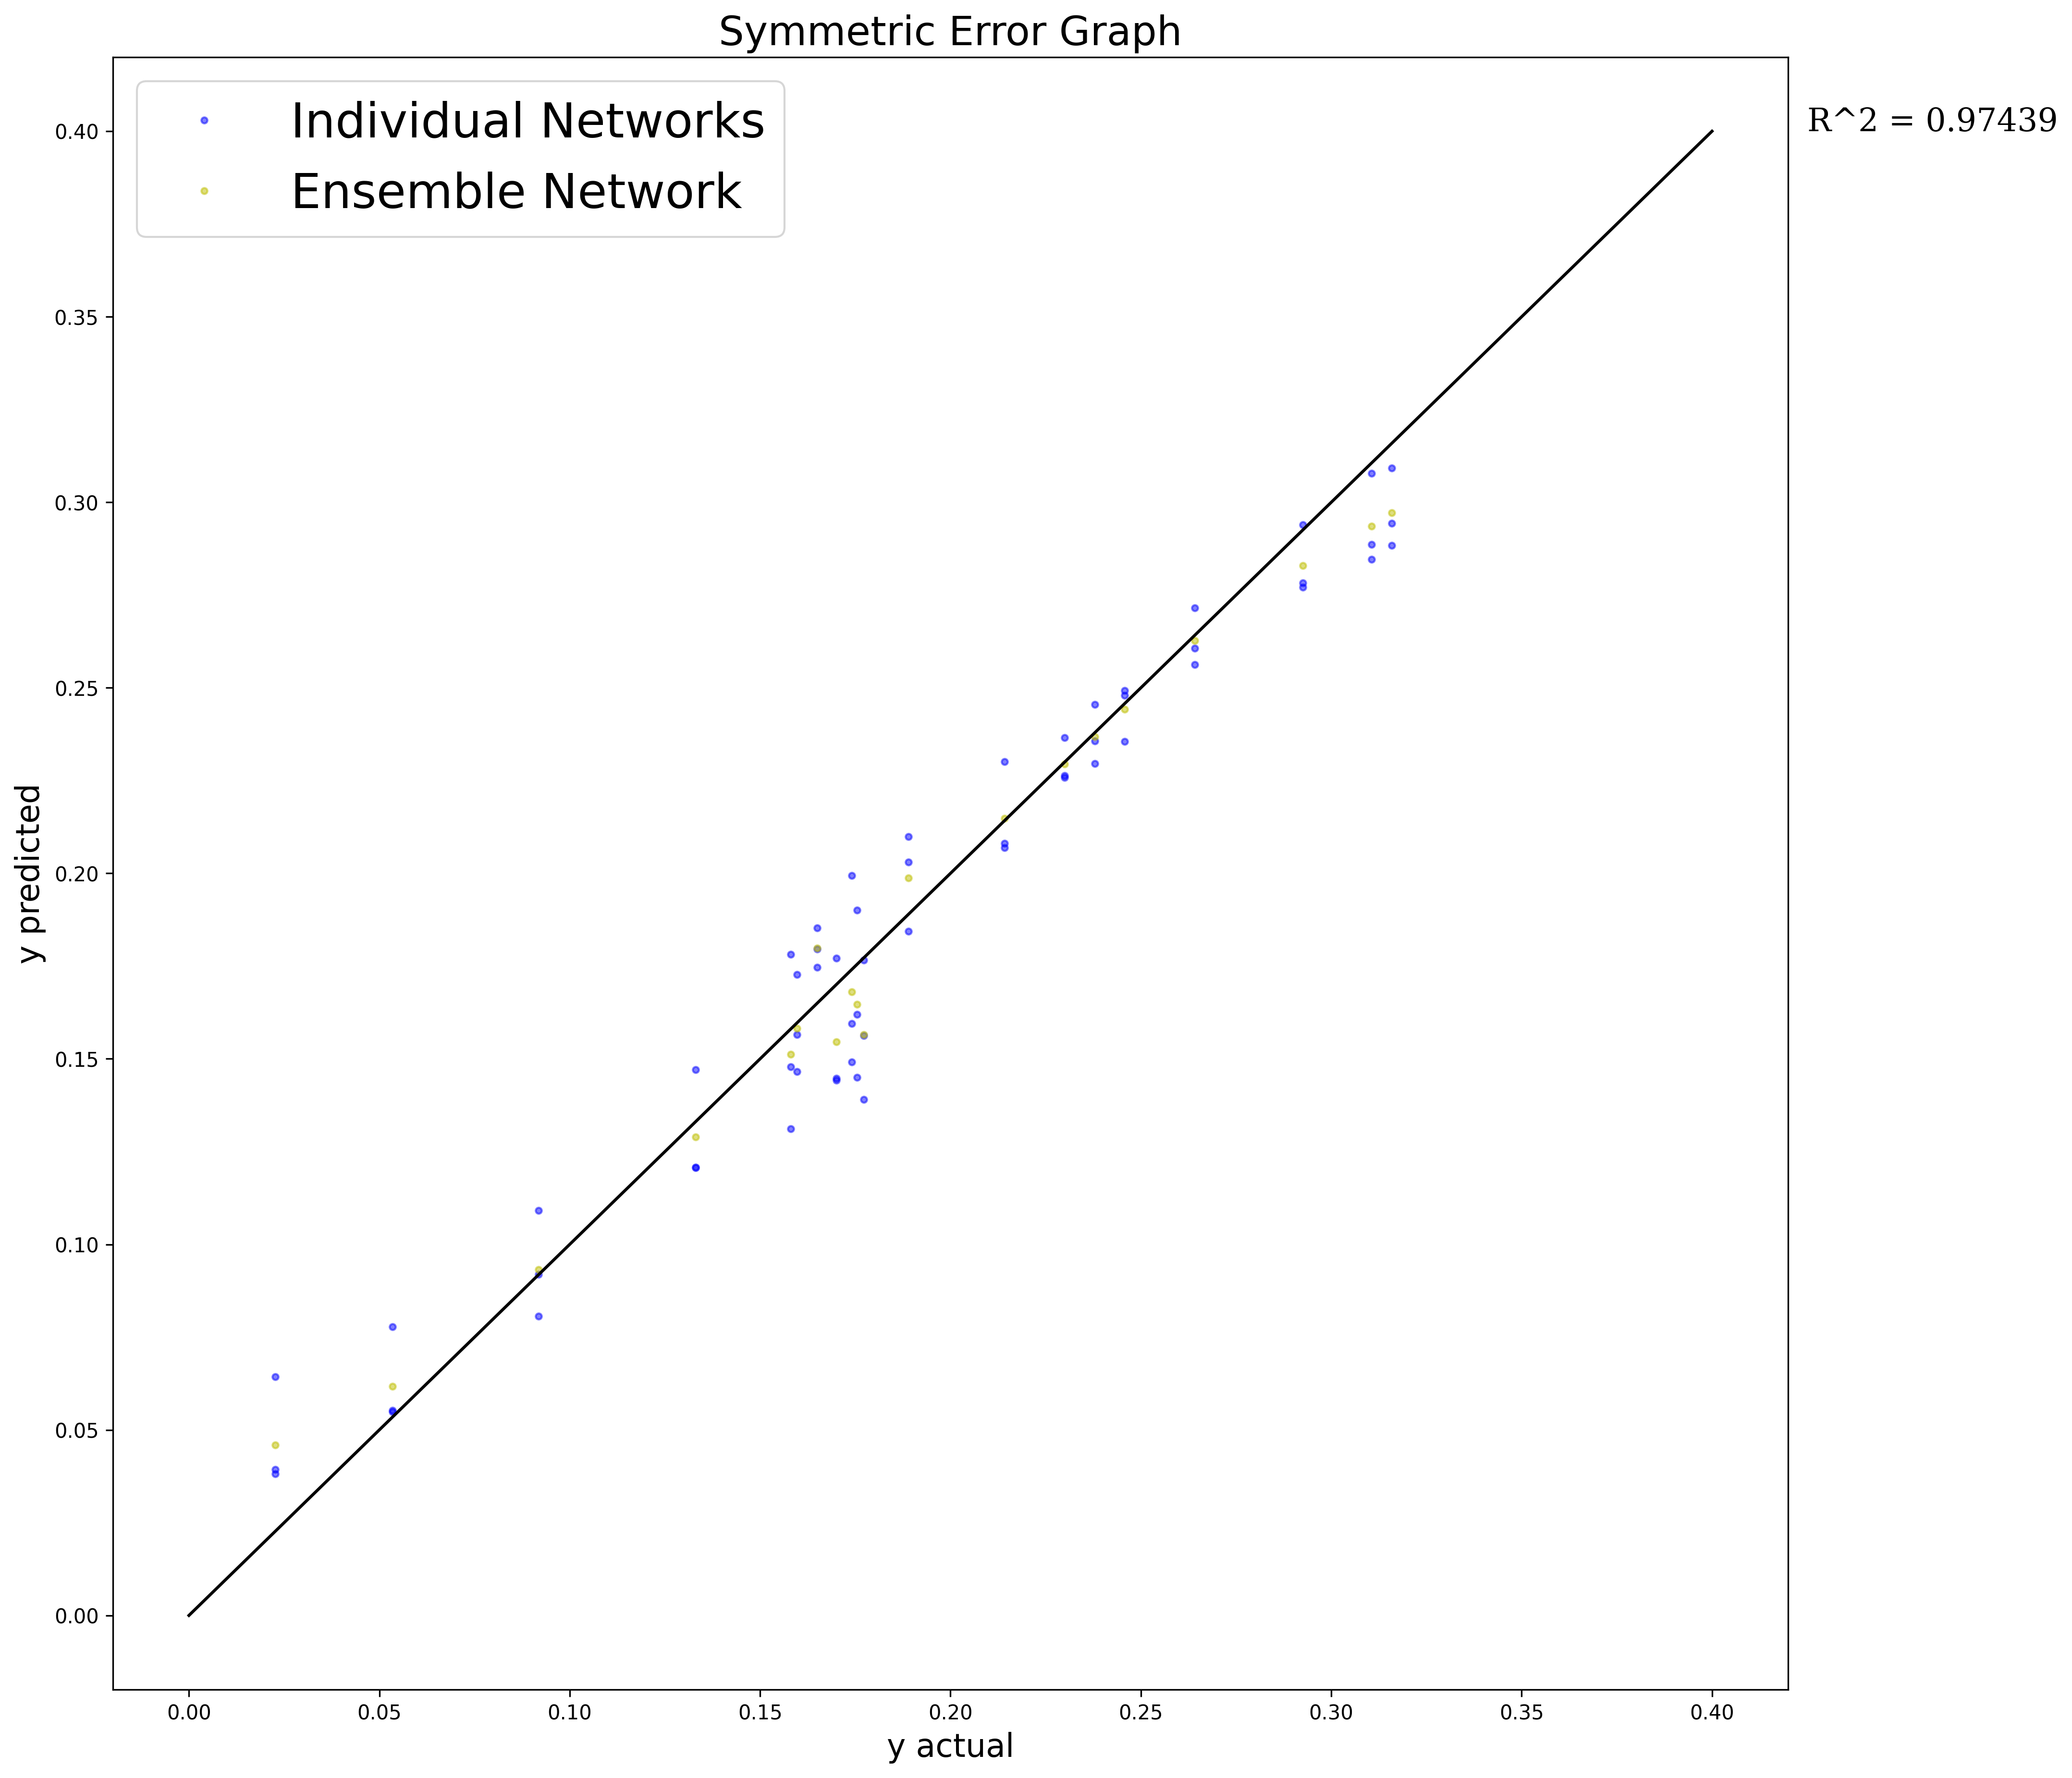

In [ ]:
# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')
a, b = 0, .4 
plt.plot([a,b],[a,b], color='black')
plt.title('Symmetric Error Graph', fontsize = 20)
plt.xlabel('y actual', fontsize = 16)
plt.ylabel('y predicted', fontsize = 16)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.425, 0.4, f"R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
plt.savefig('SymErrorGeo.jpg')
plt.show()

In [ ]:
# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
goodX, goodY = [], []
badX, badY = [], []
for i, spectra in enumerate(np.abs(y_pred - y_valid)):
  for j, ele in enumerate(spectra):
    if ele < UQ[i][j]*1.96/np.sqrt(numNetworks):
      goodY.append(ele)
      goodX.append(y_valid[i][j])
    else:
      badY.append(ele)
      badX.append(y_valid[i][j])

fig, axs = plt.subplots(1, 2, figsize=(15, 15), dpi=300)
ax[0].plot(goodX, goodY, color = ' y')
a, b = 0, .4 
ax[0].plot([a,b],[a,b], color='black')
ax[0].set_title('Good Points', fontsize = 20)
ax[0].set(xlabel='y_actual', ylabel='y_predicted')

ax[1].plot(badX, badY, color = ' y')
a, b = 0, .4 
ax[1].plot([a,b],[a,b], color='black')
ax[1].set_title('bad Points', fontsize = 20)
ax[1].set(xlabel='y_actual', ylabel='y_predicted')

In [ ]:
# DO NOT RUN UNLESS NEEDED - arithmetic not geometric graph
# Make Scatterplot Error graph with ARITHMETIC MEAN, blue is all networks, yellow is average

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictArithAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(10, 10), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')
a, b = 0, .4 
plt.plot([a,b],[a,b], color='black')
plt.title('Symmetric Error Graph', fontsize = 20)
plt.xlabel('y actual', fontsize = 16)
plt.ylabel('y predicted', fontsize = 16)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.425, 0.4, f"R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
plt.savefig('SymErrorArith.jpg')
plt.show()

NameError: ignored

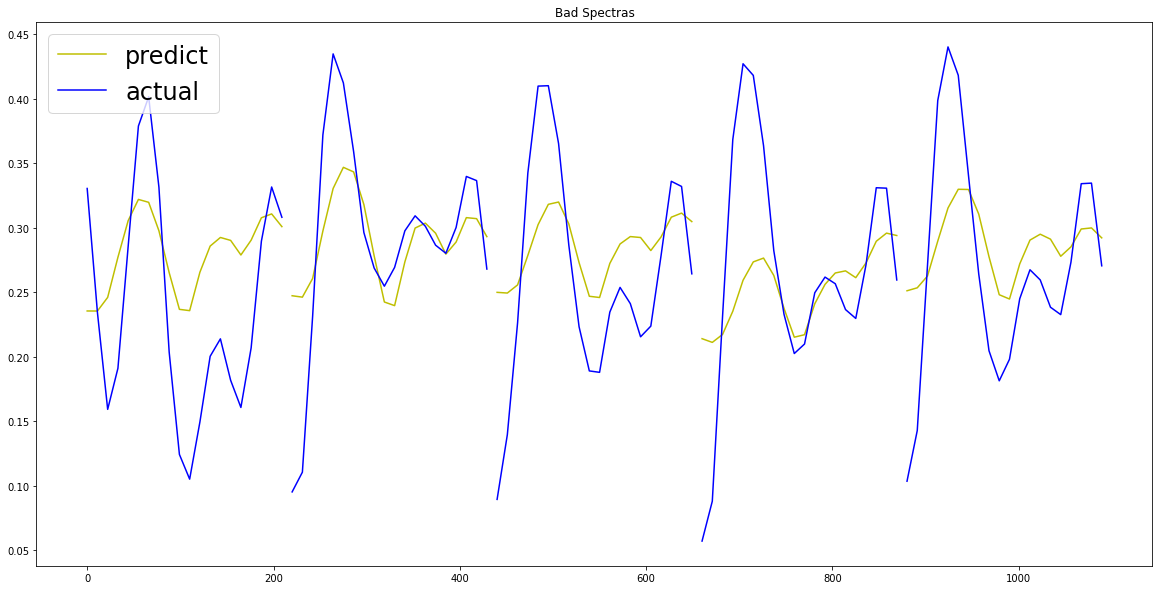

[[b'In.PM.AtFr', 23, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
----
[[b'In.PM.AtFr', 23, 1.0]]: 1
[[b'Lu.PM.AtFr', 31, 1.0]]: 4


In [ ]:
# DO NOT RUN UNLESS NEEDED - not really relevant anymore
# Puts out all very wavy spectra graphs and their associated information

bad = []
y = []
indexList = []
for i, ele in enumerate(y_valid):
  if max(ele) >= .4:
    bad.append(y_pred[i])
    y.append(ele)
    indexList.append(i)

x = np.array([x for x in range(0,220,splicingVal)])
fig = plt.figure(figsize=(20, 10))
#low, high = closest_factor(len(bad))

for j in range(10):
  for i in range(10):
    try:
      plt.plot(x + 220*i, bad[i+10*j]+.5*j, color = 'y')
      plt.plot(x + 220*i, y[i+10*j]+.5*j, color = 'b')
    except: 
      break
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Bad Spectras', fontsize = 20)
plt.savefig('Bad.jpg')
plt.show()

def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList
  
def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency
iter = 0
oxideList = []
for index in indexList:
  metal = np.transpose(hf['atfrac'])[subsetSize + index][0:42]
  #print(iter, nonZeroInList(metal))
  oxideList.append(nonZeroInList(metal))
  iter += 1
sort = sorted(oxideList, key = lambda oxide: (oxide[0][1], len(oxide), oxide[0][2]))
for each in sort:
  print(each)
print('----')
for key, value in frequencyOfItems(sort).items():
  print(f'{key}: {value}')


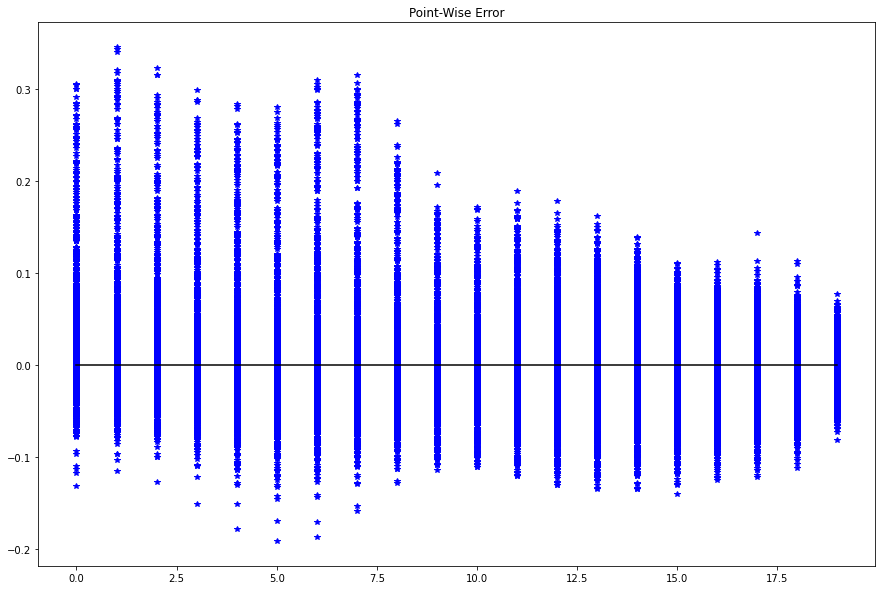

In [ ]:
# Run if you are splicing, if not spliced might be really hard to view
# Second Error graph - shows error for each point

predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(y_valid[i] - y_pred[i], '*', color = 'b')
plt.plot([0, numOutputs - 1],[0,0], color = 'black')
plt.title('Point-Wise Error', fontsize = 20)
plt.savefig('PointWiseError.jpg')
plt.show()

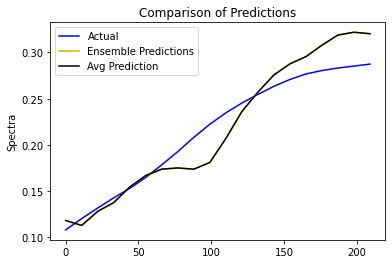

In [ ]:
# Create comparison graph of the actual spectra (blue), each networks predicted spectra (yellow), and the final averaged prediction (black)

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
plt.plot(x,spectra[0], color = 'b')
for predict in predictList:
  plt.plot(x, predict[0], color = 'y')
  plt.plot(x,y[0], color = 'black')
plt.legend(['Actual', 'Ensemble Predictions', 'Avg Prediction'], loc = 'upper left')
plt.title('Comparison of Predictions', fontsize = 20)
plt.ylabel('Spectra', fontsize = 16)
plt.savefig('PredictCompare.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Just shows various error functions to use

y0 = y_test
predictList = makePredictionsList(modelList, x_test)
y1 = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]

dy = y0-y1 # error 
abs_dy = np.abs(y0-y1)    # absolute error 
relerr = np.abs(y0-y1)/y0   # relative error 
pererr = np.abs(y0-y1)/y0*100    # percentage error 
mean_err = np.mean(np.abs(y0-y1))     # mean absolute error 
MSE = np.mean((y0-y1)**2)        # Mean square error 
RMSE = np.sqrt(np.mean((y0-y1)**2))  # Root mean square error

In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['EpochOutput.txt', 'First10.jpg', 'Random10.jpg', 'ModelAccuracyMSLE.jpg', 'ModelAccuracyMAPE.jpg', 'PredictCompare.jpg', 'Bad.jpg', 'EverySpectra.jpg', 'SymErrorGeo.jpg', 'SymErrorArith.jpg', 'PointWiseError.jpg', 'MSE_Plot.jpg', 'Random100Grid.jpg', 'AllPredictions.jpg']
for name in names:
  try:
    colab_link = name
    gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
    shutil.copy(colab_link, gdrive_link)
  except:
    print(f'{name} not downloaded')

ModelAccuracyMSLE.jpg not downloaded
ModelAccuracyMAPE.jpg not downloaded


In [ ]:
# DO NOT RUN
# Plots First 10 predictions all on the same graph
# Only use if you need to investigate oscillations in spectra graphs

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')    
  plt.legend(['predict'], loc='upper left')  
  plt.title('Combined First 10 Predictions', fontsize = 20)
plt.savefig('AllPredictions.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Attempt to implement Custom Loss Function, still a work in progress

def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
# DO NOT RUN 
# Use this only if we want to load an already built model
normal_model = load_model('Model.h5')

OSError: ignored